In [1]:
import sys
import os

sys.path.append('../')  # append parent path

In [2]:
from utils import *

In [3]:
CLIPS_ROOT = raw_clip_data
SAVE_ROOT = os.path.join(save_clip_data, 'mask_pose')
SAVE_ROOT

'/media/haruyaishikawa/new_disk/save_clip_data/mask_pose'

### Check events

In [4]:
events = [event_names[i] for i in event_ids]
events

['meal time',
 'meeting',
 'coffee break',
 'nap',
 'cooking',
 'working',
 'tending to plants']

### Activate clip management

Testing for 'coffee break':

In [17]:
coffee = events[2]
clip_id = 0

#### Show images

In [22]:
dm = ShortClipManagement(coffee, CLIPS_ROOT, SAVE_ROOT)
clips = dm.change_event(coffee)

clip = clips[clip_id]
rgb_images = dm.get_sorted_rgb_images(clip)

Using Event coffee break
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
Using Event coffee break
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']


In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

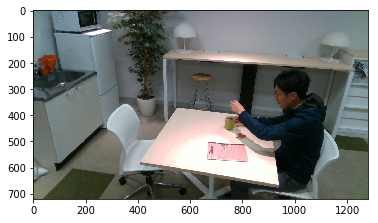

In [24]:
image_num = 100

image_path = os.path.join(dm.get_rgb_path(clip), rgb_images[image_num])

image = mpimg.imread(image_path)
plt.imshow(image)

In [6]:
manager = ClipsSavedDataManagement(event=coffee, root_path=SAVE_ROOT)

Using Event coffee break
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']


In [7]:
clips = manager.change_event(coffee)

Using Event coffee break
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']


In [8]:
clip = clips[clip_id]  # choose first clip

### Analysis

In [9]:
all_files = manager.get_sorted_npz_files(clip)
# files
print(len(all_files))

701


In [10]:
# starting point of clip
init = 100

length = len(all_files)
splits = 10
seg = int(length//splits)
print('segemnts: ', seg)

files = all_files[init:init+seg]

segemnts:  70


### Pose

In [11]:
from openpose import params, JointType

In [25]:
joint_val = JointType.Nose.value
print(JointType(joint_val))

JointType.Nose


In [12]:
joint = np.zeros((len(files), 3))
for i, f in enumerate(files):
    filename = os.path.join(manager.get_clip_directory(clip), f)
    poses, _ = poses_masks_from_npz(filename)

    if not(poses is None):
        pose_ids = list(poses.keys())
        points = poses[pose_ids[0]]

        point = points[joint_val]
        if (point == [0,0,0]).all():
            joint[i] = np.asarray([np.nan, np.nan, np.nan])
        else:
            joint[i] = point

roll_joint = np.rollaxis(joint, 1)

JointType.Nose


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [96]:
# in milimeters
y_min = -2000
y_max = 2000
x_min = -2000
x_max = 2000
bin_x = 100
bin_y = 100

def show_location_map(points, name):
    xedges = [i for i in range(x_min, x_max, bin_x)]
    yedges = [i for i in range(y_min, y_max, bin_y)]

    x = points[0][~np.isnan(points[0])]
    y = points[1][~np.isnan(points[1])]
    # z = points[2][~np.isnan(points[2])]

    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    H = H.T


    fig = plt.figure()

    ax = fig.add_subplot(111, title=name,
                        aspect='equal')
    X, Y = np.meshgrid(xedges, yedges)
    #ax.pcolormesh(X, Y, H)
    ax.pcolor(X, Y, H)

    # non uniform image:

    # ax = fig.add_subplot(111, title='NonUniformImage: interpolated',
    #                      aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
    # im = mpl.image.NonUniformImage(ax, interpolation='bilinear')
    # xcenters = (xedges[:-1] + xedges[1:]) / 2
    # ycenters = (yedges[:-1] + yedges[1:]) / 2
    # im.set_data(xcenters, ycenters, H)
    # ax.images.append(im)
    plt.show()


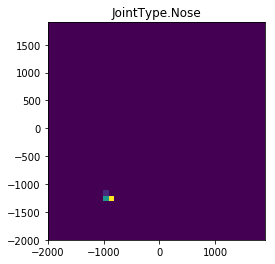

In [97]:
show_location_map(roll_joint, JointType(joint_val))

#### Object

In [91]:
ob_name = 'person'

calculate mean per each image

In [92]:
mean_of_points = []
for i, f in enumerate(files):
    filename = os.path.join(manager.get_clip_directory(clip), f)
    _, masks = poses_masks_from_npz(filename)

    if masks is None:
        continue

    item_number = [i for i, j in object_dict.items() if j == ob_name]

    for mask in masks:

        # TODO:
        # get string name
        # check if the first digit is some class
        # if so, append the mean
        id = int(mask.split('_')[0])

        if id in item_number:
            mean = masks[mask].mean(0)
            mean_of_points.append(mean)

mp = np.asarray(mean_of_points)
if mp.any() == False:
    print("no such object ", ob_name, " detected")

mp = np.rollaxis(mp, 1)

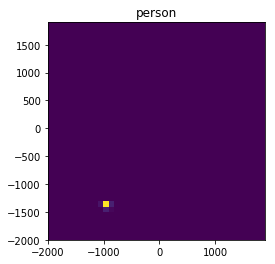

In [93]:
show_location_map(mp, ob_name)

plot all points

In [94]:
all_points = None

for i, f in enumerate(files):
    filename = os.path.join(manager.get_clip_directory(clip), f)
    _, masks = poses_masks_from_npz(filename)
    
    if masks is None:
        continue

    item_index = coco_label_names.index(ob_name)
    
    for mask in masks:
        # get string name
        # check if the first digit is some class
        # if so, append the mean
        id = int(mask.split('_')[0])

        if id == item_index:
            if all_points is None:
                all_points = masks[mask]
            else:
                all_points = np.concatenate((all_points, masks[mask]), axis=0)

if all_points is None:
    print("no such object ", ob_name, " detected")


print(all_points.shape)
all_points = np.rollaxis(all_points, 1)

(245821, 3)


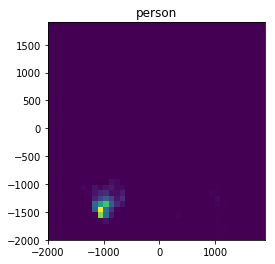

In [98]:
show_location_map(all_points, ob_name)

In [ ]:
for 